# 12 目标检测与分割入门

> 从分类到检测与分割：CNN 的应用扩展

---

**本章重点**：理解目标检测和语义分割的核心概念，从零实现 IoU、NMS，并构建简化版 YOLO 和完整 U-Net。

## 📚 学习目标

- [ ] 理解分类、检测、分割任务的区别
- [ ] **从零实现 IoU（交并比）计算**
- [ ] **从零实现 NMS（非极大值抑制）**
- [ ] 理解 YOLO 的核心思想
- [ ] 理解 U-Net 的编码器-解码器结构
- [ ] **从零实现完整的 U-Net**
- [ ] 使用预训练模型进行检测和分割

## 🔍 前置知识

在开始之前，请确保你已经掌握：

- **05_cnn_architecture.ipynb** - CNN 的基本构建块
- **07_classic_architectures.ipynb** - ResNet 和残差连接
- **10_modern_efficient_architectures.ipynb** - 深度可分离卷积

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import warnings
warnings.filterwarnings('ignore')

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# 设置设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用设备: {device}")

# 设置随机种子
torch.manual_seed(42)
np.random.seed(42)

使用设备: cpu


---

# Part 1: 从分类到检测

## 1.1 任务层次

计算机视觉任务可以按「输出粒度」分类：

| 任务 | 输出 | 粒度 | 示例 |
|------|------|------|------|
| **图像分类** | 一个类别标签 | 图像级 | 这是一只猫 |
| **目标检测** | 多个边界框 + 类别 | 物体级 | 左上角有一只猫，右下角有一只狗 |
| **语义分割** | 每个像素的类别 | 像素级 | 哪些像素属于猫，哪些属于狗 |
| **实例分割** | 每个物体的像素掩码 | 实例级 | 这只猫的像素，那只猫的像素 |

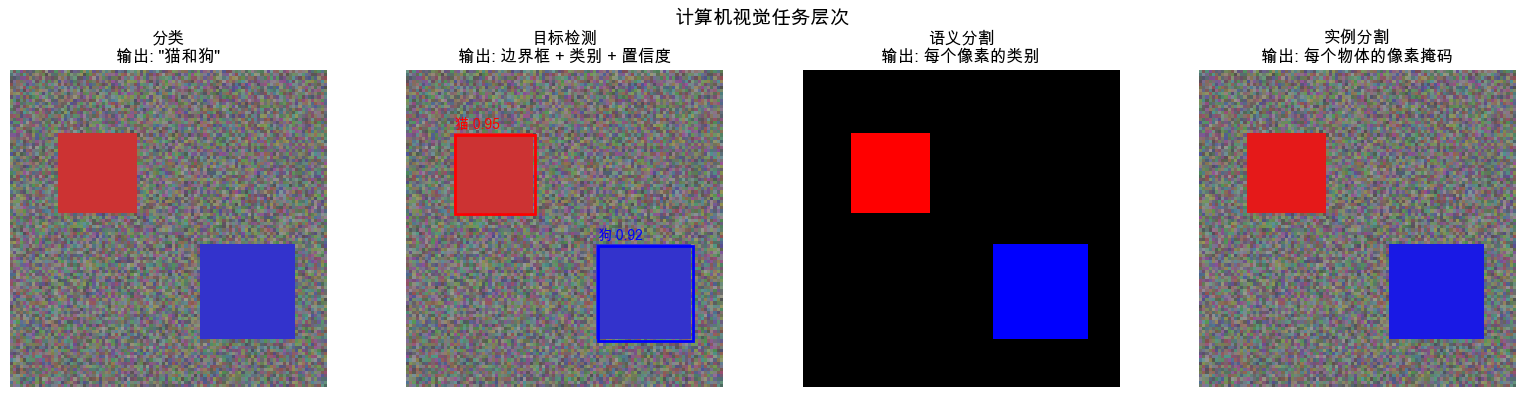

💡 本章重点：
   - 目标检测：YOLO 系列
   - 语义分割：U-Net


In [2]:
# 可视化不同任务的输出

fig, axes = plt.subplots(1, 4, figsize=(16, 4))

# 创建模拟图像
np.random.seed(42)
img = np.random.rand(100, 100, 3) * 0.3 + 0.3  # 背景

# 添加两个"物体"
img[20:45, 15:40] = [0.8, 0.2, 0.2]  # 红色物体（猫）
img[55:85, 60:90] = [0.2, 0.2, 0.8]  # 蓝色物体（狗）

# 1. 分类
axes[0].imshow(img)
axes[0].set_title('分类\n输出: "猫和狗"', fontsize=12)
axes[0].axis('off')

# 2. 检测
axes[1].imshow(img)
rect1 = patches.Rectangle((15, 20), 25, 25, linewidth=2, edgecolor='red', facecolor='none')
rect2 = patches.Rectangle((60, 55), 30, 30, linewidth=2, edgecolor='blue', facecolor='none')
axes[1].add_patch(rect1)
axes[1].add_patch(rect2)
axes[1].text(15, 18, '猫 0.95', color='red', fontsize=10, fontweight='bold')
axes[1].text(60, 53, '狗 0.92', color='blue', fontsize=10, fontweight='bold')
axes[1].set_title('目标检测\n输出: 边界框 + 类别 + 置信度', fontsize=12)
axes[1].axis('off')

# 3. 语义分割
seg_mask = np.zeros((100, 100, 3))
seg_mask[20:45, 15:40] = [1, 0, 0]  # 红色 = 猫
seg_mask[55:85, 60:90] = [0, 0, 1]  # 蓝色 = 狗
axes[2].imshow(seg_mask)
axes[2].set_title('语义分割\n输出: 每个像素的类别', fontsize=12)
axes[2].axis('off')

# 4. 实例分割
axes[3].imshow(img)
# 用不同颜色的半透明遮罩
mask1 = np.zeros((100, 100, 4))
mask1[20:45, 15:40] = [1, 0, 0, 0.5]
mask2 = np.zeros((100, 100, 4))
mask2[55:85, 60:90] = [0, 0, 1, 0.5]
axes[3].imshow(mask1)
axes[3].imshow(mask2)
axes[3].set_title('实例分割\n输出: 每个物体的像素掩码', fontsize=12)
axes[3].axis('off')

plt.suptitle('计算机视觉任务层次', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("💡 本章重点：")
print("   - 目标检测：YOLO 系列")
print("   - 语义分割：U-Net")

## 1.2 Two-stage vs One-stage 检测方法

### Two-stage（两阶段）

1. **阶段1**：生成候选区域（Region Proposals）
2. **阶段2**：对每个候选区域分类和回归

代表：R-CNN、Fast R-CNN、Faster R-CNN

### One-stage（单阶段）

直接从图像预测边界框和类别，无候选区域步骤。

代表：YOLO、SSD、RetinaNet

| 特点 | Two-stage | One-stage |
|------|-----------|----------|
| 速度 | 慢 | 快 |
| 精度 | 高 | 中等（但不断提升）|
| 适用场景 | 高精度要求 | 实时检测 |

---

# Part 2: 核心概念 ⭐必须掌握

## 2.1 锚框（Anchor Box）

**锚框**是目标检测中预定义的一组边界框模板。

### 为什么需要锚框？

1. **简化问题**：不是从无限可能中搜索框，而是基于锚框进行调整
2. **处理多尺度**：不同大小的锚框检测不同大小的物体
3. **处理多比例**：不同宽高比的锚框检测不同形状的物体

In [3]:
def generate_anchors(image_size, grid_size, anchor_sizes, anchor_ratios):
    """
    生成锚框
    
    参数:
        image_size: 图像尺寸 (H, W)
        grid_size: 网格尺寸 (gh, gw)
        anchor_sizes: 锚框基础尺寸列表
        anchor_ratios: 锚框宽高比列表
    
    返回:
        anchors: 所有锚框, shape (gh*gw*num_anchors, 4)
                 每个锚框格式: (cx, cy, w, h)
    """
    H, W = image_size
    gh, gw = grid_size
    
    # 每个格子的步长
    stride_h = H / gh
    stride_w = W / gw
    
    anchors = []
    
    # 遍历每个网格位置
    for i in range(gh):
        for j in range(gw):
            # 格子中心坐标
            cx = (j + 0.5) * stride_w
            cy = (i + 0.5) * stride_h
            
            # 在该位置生成所有尺寸和比例的锚框
            for size in anchor_sizes:
                for ratio in anchor_ratios:
                    w = size * np.sqrt(ratio)
                    h = size / np.sqrt(ratio)
                    anchors.append([cx, cy, w, h])
    
    return np.array(anchors)


# 生成示例锚框
image_size = (416, 416)
grid_size = (7, 7)
anchor_sizes = [32, 64, 128]  # 3 种尺寸
anchor_ratios = [0.5, 1.0, 2.0]  # 3 种宽高比

anchors = generate_anchors(image_size, grid_size, anchor_sizes, anchor_ratios)
print(f"生成的锚框数量: {len(anchors)}")
print(f"  = {grid_size[0]} × {grid_size[1]} 个格子")
print(f"  × {len(anchor_sizes)} 种尺寸")
print(f"  × {len(anchor_ratios)} 种比例")
print(f"  = {grid_size[0] * grid_size[1] * len(anchor_sizes) * len(anchor_ratios)} 个锚框")

生成的锚框数量: 441
  = 7 × 7 个格子
  × 3 种尺寸
  × 3 种比例
  = 441 个锚框


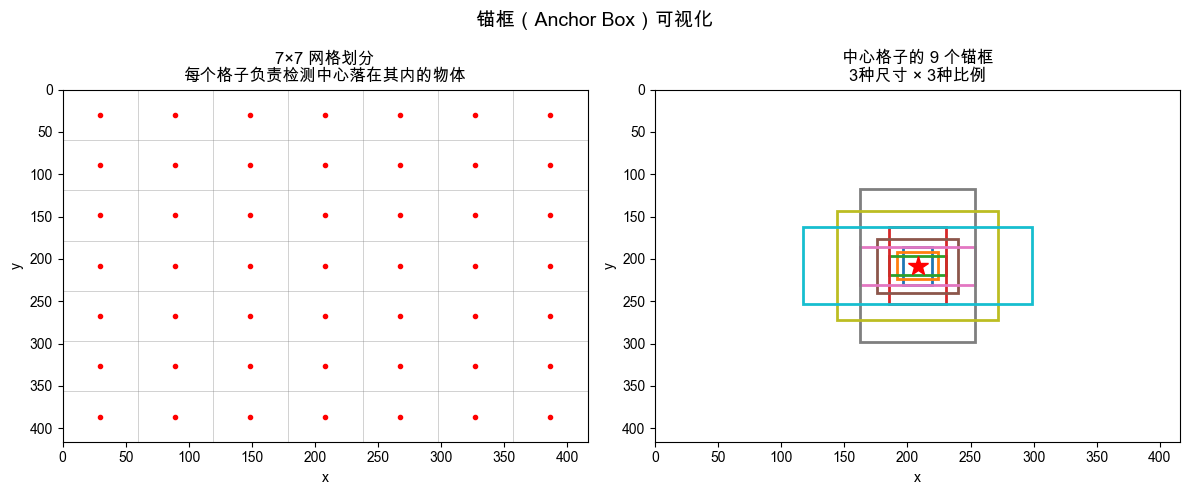

In [4]:
# 可视化锚框

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 1. 网格和中心点
axes[0].set_xlim(0, 416)
axes[0].set_ylim(416, 0)  # y 轴反转

# 画网格
for i in range(8):
    axes[0].axhline(y=i * 416/7, color='gray', linewidth=0.5, alpha=0.5)
    axes[0].axvline(x=i * 416/7, color='gray', linewidth=0.5, alpha=0.5)

# 画每个格子的中心点
for i in range(7):
    for j in range(7):
        cx = (j + 0.5) * 416/7
        cy = (i + 0.5) * 416/7
        axes[0].plot(cx, cy, 'ro', markersize=3)

axes[0].set_title('7×7 网格划分\n每个格子负责检测中心落在其内的物体')
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')

# 2. 某个位置的所有锚框
axes[1].set_xlim(0, 416)
axes[1].set_ylim(416, 0)

# 选择中心格子 (3, 3)
center_idx = 3 * 7 + 3  # 第 3 行第 3 列
num_anchors_per_cell = len(anchor_sizes) * len(anchor_ratios)
start_idx = center_idx * num_anchors_per_cell
end_idx = start_idx + num_anchors_per_cell

center_anchors = anchors[start_idx:end_idx]
colors = plt.cm.tab10(np.linspace(0, 1, num_anchors_per_cell))

for idx, (anchor, color) in enumerate(zip(center_anchors, colors)):
    cx, cy, w, h = anchor
    x1 = cx - w/2
    y1 = cy - h/2
    rect = patches.Rectangle((x1, y1), w, h, linewidth=2, 
                              edgecolor=color, facecolor='none')
    axes[1].add_patch(rect)

axes[1].plot(center_anchors[0, 0], center_anchors[0, 1], 'r*', markersize=15)
axes[1].set_title(f'中心格子的 {num_anchors_per_cell} 个锚框\n3种尺寸 × 3种比例')
axes[1].set_xlabel('x')
axes[1].set_ylabel('y')

plt.suptitle('锚框（Anchor Box）可视化', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 2.2 IoU 交并比

**IoU（Intersection over Union）**是衡量两个边界框重叠程度的指标。

$$\text{IoU} = \frac{\text{交集面积}}{\text{并集面积}} = \frac{|A \cap B|}{|A \cup B|}$$

- IoU = 0：完全不重叠
- IoU = 1：完全重叠
- 通常 IoU > 0.5 认为检测正确

In [5]:
def compute_iou(box1, box2):
    """
    计算两个边界框的 IoU
    
    从零实现 IoU 计算
    
    参数:
        box1: 第一个边界框 [x1, y1, x2, y2]（左上角和右下角坐标）
        box2: 第二个边界框 [x1, y1, x2, y2]
    
    返回:
        iou: 交并比，范围 [0, 1]
    """
    # ========================================
    # 第1步：计算交集区域的坐标
    # 交集的左上角 = 两个框左上角的最大值
    # 交集的右下角 = 两个框右下角的最小值
    # ========================================
    inter_x1 = max(box1[0], box2[0])  # 交集左边界
    inter_y1 = max(box1[1], box2[1])  # 交集上边界
    inter_x2 = min(box1[2], box2[2])  # 交集右边界
    inter_y2 = min(box1[3], box2[3])  # 交集下边界
    
    # ========================================
    # 第2步：计算交集面积
    # 如果没有交集，宽或高会是负数，需要 clamp 到 0
    # ========================================
    inter_width = max(0, inter_x2 - inter_x1)
    inter_height = max(0, inter_y2 - inter_y1)
    inter_area = inter_width * inter_height
    
    # ========================================
    # 第3步：计算两个框各自的面积
    # ========================================
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    
    # ========================================
    # 第4步：计算并集面积
    # 并集 = A + B - 交集（避免重复计算）
    # ========================================
    union_area = box1_area + box2_area - inter_area
    
    # ========================================
    # 第5步：计算 IoU
    # ========================================
    iou = inter_area / (union_area + 1e-6)  # 加小数防止除零
    
    return iou


# 测试 IoU 计算
print("IoU 计算测试")
print("=" * 50)

# 测试用例 1：部分重叠
box1 = [0, 0, 10, 10]   # 面积 100
box2 = [5, 5, 15, 15]   # 面积 100，交集 25
iou1 = compute_iou(box1, box2)
print(f"部分重叠: IoU = {iou1:.4f} (理论值: 25/(100+100-25) = 0.1429)")

# 测试用例 2：完全重叠
box3 = [0, 0, 10, 10]
box4 = [0, 0, 10, 10]
iou2 = compute_iou(box3, box4)
print(f"完全重叠: IoU = {iou2:.4f} (理论值: 1.0)")

# 测试用例 3：无重叠
box5 = [0, 0, 10, 10]
box6 = [20, 20, 30, 30]
iou3 = compute_iou(box5, box6)
print(f"无重叠: IoU = {iou3:.4f} (理论值: 0.0)")

IoU 计算测试
部分重叠: IoU = 0.1429 (理论值: 25/(100+100-25) = 0.1429)
完全重叠: IoU = 1.0000 (理论值: 1.0)
无重叠: IoU = 0.0000 (理论值: 0.0)


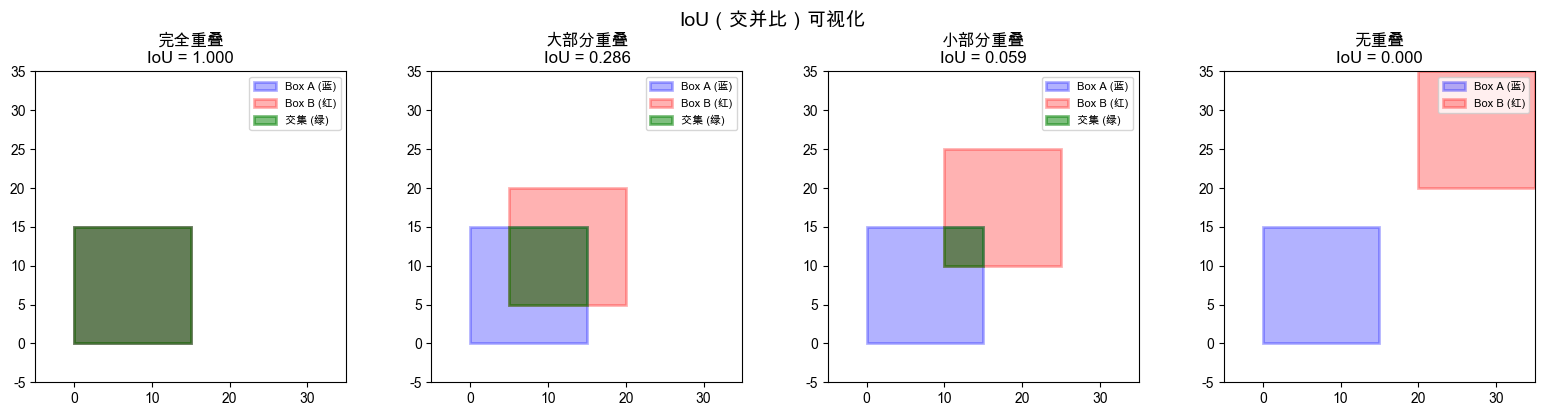

In [6]:
# IoU 可视化

def visualize_iou(box1, box2, ax, title):
    """可视化两个框的 IoU"""
    iou = compute_iou(box1, box2)
    
    # 绘制两个框
    rect1 = patches.Rectangle((box1[0], box1[1]), box1[2]-box1[0], box1[3]-box1[1],
                               linewidth=2, edgecolor='blue', facecolor='blue', alpha=0.3)
    rect2 = patches.Rectangle((box2[0], box2[1]), box2[2]-box2[0], box2[3]-box2[1],
                               linewidth=2, edgecolor='red', facecolor='red', alpha=0.3)
    ax.add_patch(rect1)
    ax.add_patch(rect2)
    
    # 计算交集区域
    inter_x1 = max(box1[0], box2[0])
    inter_y1 = max(box1[1], box2[1])
    inter_x2 = min(box1[2], box2[2])
    inter_y2 = min(box1[3], box2[3])
    
    if inter_x2 > inter_x1 and inter_y2 > inter_y1:
        rect_inter = patches.Rectangle((inter_x1, inter_y1), inter_x2-inter_x1, inter_y2-inter_y1,
                                        linewidth=2, edgecolor='green', facecolor='green', alpha=0.5)
        ax.add_patch(rect_inter)
    
    ax.set_xlim(-5, 35)
    ax.set_ylim(-5, 35)
    ax.set_aspect('equal')
    ax.set_title(f'{title}\nIoU = {iou:.3f}')
    ax.legend(['Box A (蓝)', 'Box B (红)', '交集 (绿)'], loc='upper right', fontsize=8)

fig, axes = plt.subplots(1, 4, figsize=(16, 4))

# 不同重叠程度
cases = [
    ([0, 0, 15, 15], [0, 0, 15, 15], '完全重叠'),
    ([0, 0, 15, 15], [5, 5, 20, 20], '大部分重叠'),
    ([0, 0, 15, 15], [10, 10, 25, 25], '小部分重叠'),
    ([0, 0, 15, 15], [20, 20, 35, 35], '无重叠'),
]

for ax, (b1, b2, title) in zip(axes, cases):
    visualize_iou(b1, b2, ax, title)

plt.suptitle('IoU（交并比）可视化', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [7]:
def compute_iou_batch(boxes1, boxes2):
    """
    批量计算 IoU（向量化版本）
    
    参数:
        boxes1: 第一组框, shape (N, 4), 格式 [x1, y1, x2, y2]
        boxes2: 第二组框, shape (M, 4)
    
    返回:
        iou_matrix: IoU 矩阵, shape (N, M)
                    iou_matrix[i, j] = IoU(boxes1[i], boxes2[j])
    """
    N = boxes1.shape[0]
    M = boxes2.shape[0]
    
    # 扩展维度以便广播
    # boxes1: (N, 1, 4)
    # boxes2: (1, M, 4)
    boxes1 = boxes1[:, np.newaxis, :]
    boxes2 = boxes2[np.newaxis, :, :]
    
    # 计算交集坐标
    inter_x1 = np.maximum(boxes1[..., 0], boxes2[..., 0])
    inter_y1 = np.maximum(boxes1[..., 1], boxes2[..., 1])
    inter_x2 = np.minimum(boxes1[..., 2], boxes2[..., 2])
    inter_y2 = np.minimum(boxes1[..., 3], boxes2[..., 3])
    
    # 交集面积
    inter_area = np.maximum(0, inter_x2 - inter_x1) * np.maximum(0, inter_y2 - inter_y1)
    
    # 各自面积
    area1 = (boxes1[..., 2] - boxes1[..., 0]) * (boxes1[..., 3] - boxes1[..., 1])
    area2 = (boxes2[..., 2] - boxes2[..., 0]) * (boxes2[..., 3] - boxes2[..., 1])
    
    # 并集面积
    union_area = area1 + area2 - inter_area
    
    # IoU
    iou = inter_area / (union_area + 1e-6)
    
    return iou


# 测试批量 IoU
print("批量 IoU 计算测试")
print("=" * 50)

boxes1 = np.array([
    [0, 0, 10, 10],
    [5, 5, 15, 15],
])

boxes2 = np.array([
    [0, 0, 10, 10],
    [5, 5, 15, 15],
    [20, 20, 30, 30],
])

iou_matrix = compute_iou_batch(boxes1, boxes2)
print(f"boxes1 形状: {boxes1.shape}")
print(f"boxes2 形状: {boxes2.shape}")
print(f"IoU 矩阵形状: {iou_matrix.shape}")
print(f"\nIoU 矩阵:\n{iou_matrix}")

批量 IoU 计算测试
boxes1 形状: (2, 4)
boxes2 形状: (3, 4)
IoU 矩阵形状: (2, 3)

IoU 矩阵:
[[0.99999999 0.14285714 0.        ]
 [0.14285714 0.99999999 0.        ]]


## 2.3 NMS 非极大值抑制

**NMS（Non-Maximum Suppression）**用于去除重复检测。

### 问题背景

检测器通常会对同一个物体产生多个重叠的检测框，需要保留最好的一个。

### NMS 算法流程

1. 按置信度排序所有检测框
2. 选择置信度最高的框，加入结果
3. 删除与该框 IoU > 阈值的其他框
4. 重复 2-3 直到没有框剩余

In [8]:
def nms(boxes, scores, iou_threshold=0.5):
    """
    非极大值抑制的从零实现
    
    参数:
        boxes: 边界框, shape (N, 4), 格式 [x1, y1, x2, y2]
        scores: 每个框的置信度, shape (N,)
        iou_threshold: IoU 阈值，超过此值的框会被抑制
    
    返回:
        keep: 保留的框的索引列表
    """
    # ========================================
    # 第1步：按置信度降序排序
    # ========================================
    order = np.argsort(scores)[::-1]  # 降序排列的索引
    
    keep = []  # 保留的框的索引
    
    # ========================================
    # 第2步：贪心选择
    # ========================================
    while len(order) > 0:
        # 选择当前置信度最高的框
        current = order[0]
        keep.append(current)
        
        # 如果只剩一个框，结束
        if len(order) == 1:
            break
        
        # 计算当前框与其他所有框的 IoU
        current_box = boxes[current]
        other_boxes = boxes[order[1:]]
        
        ious = np.array([compute_iou(current_box, box) for box in other_boxes])
        
        # 保留 IoU <= 阈值的框（即不重叠的框）
        mask = ious <= iou_threshold
        order = order[1:][mask]
    
    return keep


# 测试 NMS
print("NMS 测试")
print("=" * 50)

# 模拟检测结果：一个物体有多个重叠框
boxes = np.array([
    [100, 100, 200, 200],  # 框 0
    [105, 105, 205, 205],  # 框 1，与框 0 高度重叠
    [110, 110, 210, 210],  # 框 2，与框 0、1 高度重叠
    [300, 300, 400, 400],  # 框 3，另一个物体
    [305, 305, 405, 405],  # 框 4，与框 3 高度重叠
])

scores = np.array([0.9, 0.85, 0.8, 0.95, 0.7])

keep = nms(boxes, scores, iou_threshold=0.5)

print(f"输入框数量: {len(boxes)}")
print(f"置信度: {scores}")
print(f"NMS 后保留的索引: {keep}")
print(f"保留的框数量: {len(keep)}")
print(f"保留的置信度: {scores[keep]}")

NMS 测试
输入框数量: 5
置信度: [0.9  0.85 0.8  0.95 0.7 ]
NMS 后保留的索引: [3, 0]
保留的框数量: 2
保留的置信度: [0.95 0.9 ]


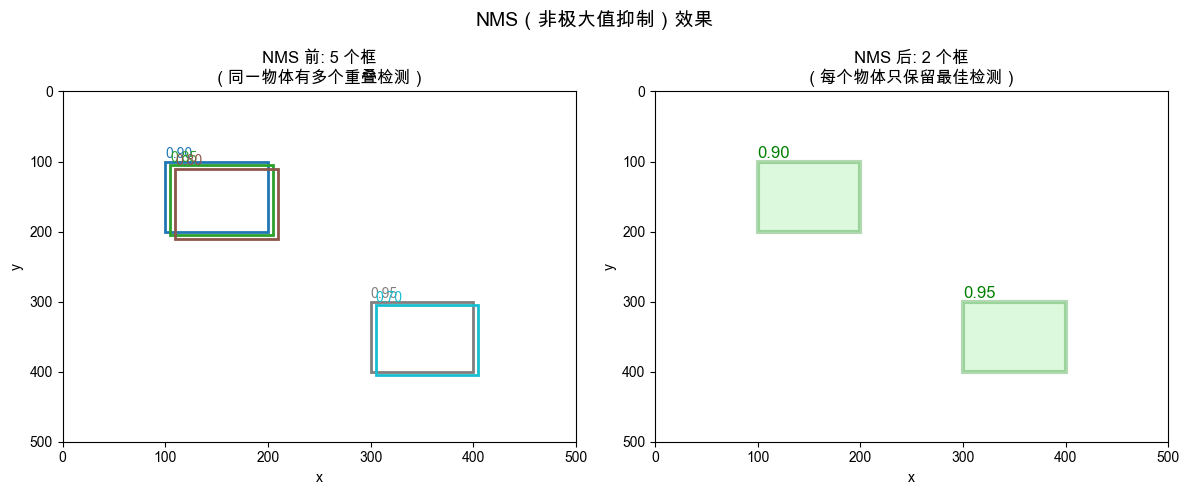

💡 NMS 的作用：
   - 去除对同一物体的重复检测
   - 保留置信度最高的框
   - 是目标检测后处理的关键步骤


In [9]:
# NMS 效果可视化

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# NMS 前
axes[0].set_xlim(0, 500)
axes[0].set_ylim(500, 0)

colors = plt.cm.tab10(np.linspace(0, 1, len(boxes)))
for i, (box, score, color) in enumerate(zip(boxes, scores, colors)):
    rect = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1],
                              linewidth=2, edgecolor=color, facecolor='none')
    axes[0].add_patch(rect)
    axes[0].text(box[0], box[1]-5, f'{score:.2f}', color=color, fontsize=10)

axes[0].set_title(f'NMS 前: {len(boxes)} 个框\n（同一物体有多个重叠检测）')
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')

# NMS 后
axes[1].set_xlim(0, 500)
axes[1].set_ylim(500, 0)

for idx in keep:
    box = boxes[idx]
    score = scores[idx]
    rect = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1],
                              linewidth=3, edgecolor='green', facecolor='lightgreen', alpha=0.3)
    axes[1].add_patch(rect)
    axes[1].text(box[0], box[1]-5, f'{score:.2f}', color='green', fontsize=12, fontweight='bold')

axes[1].set_title(f'NMS 后: {len(keep)} 个框\n（每个物体只保留最佳检测）')
axes[1].set_xlabel('x')
axes[1].set_ylabel('y')

plt.suptitle('NMS（非极大值抑制）效果', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("💡 NMS 的作用：")
print("   - 去除对同一物体的重复检测")
print("   - 保留置信度最高的框")
print("   - 是目标检测后处理的关键步骤")

---

# Part 3: YOLO 思想与简化实现 ⭐

## 3.1 YOLO 核心思想

**YOLO（You Only Look Once）**将检测视为回归问题：

1. 将图像划分为 S×S 的网格
2. 每个网格预测 B 个边界框和 C 个类别概率
3. 一次前向传播完成所有预测

In [10]:
print("""
YOLO 输出张量结构
================================================================================

假设：
- S = 7（7×7 网格）
- B = 2（每个格子预测 2 个框）
- C = 20（20 个类别，如 VOC 数据集）

输出张量形状：S × S × (B × 5 + C) = 7 × 7 × (2 × 5 + 20) = 7 × 7 × 30

每个格子的 30 维向量：
┌────────────────────────────────────────────────────────────────────────────┐
│  Box 1 (5个值)      │  Box 2 (5个值)      │  类别概率 (20个值)              │
│  [x, y, w, h, conf] │  [x, y, w, h, conf] │  [P(class_1), ..., P(class_20)]│
├────────────────────────────────────────────────────────────────────────────┤
│  索引 0-4           │  索引 5-9           │  索引 10-29                     │
└────────────────────────────────────────────────────────────────────────────┘

其中：
- (x, y): 边界框中心相对于格子左上角的偏移，范围 [0, 1]
- (w, h): 边界框宽高相对于整个图像的比例，范围 [0, 1]
- conf: 置信度 = P(Object) × IoU(pred, truth)
- P(class_i): 在有物体的条件下，属于类别 i 的概率

================================================================================
""")


YOLO 输出张量结构

假设：
- S = 7（7×7 网格）
- B = 2（每个格子预测 2 个框）
- C = 20（20 个类别，如 VOC 数据集）

输出张量形状：S × S × (B × 5 + C) = 7 × 7 × (2 × 5 + 20) = 7 × 7 × 30

每个格子的 30 维向量：
┌────────────────────────────────────────────────────────────────────────────┐
│  Box 1 (5个值)      │  Box 2 (5个值)      │  类别概率 (20个值)              │
│  [x, y, w, h, conf] │  [x, y, w, h, conf] │  [P(class_1), ..., P(class_20)]│
├────────────────────────────────────────────────────────────────────────────┤
│  索引 0-4           │  索引 5-9           │  索引 10-29                     │
└────────────────────────────────────────────────────────────────────────────┘

其中：
- (x, y): 边界框中心相对于格子左上角的偏移，范围 [0, 1]
- (w, h): 边界框宽高相对于整个图像的比例，范围 [0, 1]
- conf: 置信度 = P(Object) × IoU(pred, truth)
- P(class_i): 在有物体的条件下，属于类别 i 的概率




In [11]:
class SimpleYOLOHead(nn.Module):
    """
    简化版 YOLO 检测头
    
    输入: 特征图 (N, in_channels, H, W)
    输出: 检测结果 (N, S, S, B*5 + C)
    
    参数:
        in_channels: 输入特征通道数
        S: 网格大小
        B: 每个格子预测的框数
        C: 类别数
    """
    
    def __init__(self, in_channels, S=7, B=2, C=20):
        super().__init__()
        
        self.S = S
        self.B = B
        self.C = C
        
        # 输出通道数
        out_channels = B * 5 + C  # 每个格子的输出维度
        
        # 检测头：几层卷积
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1),
            
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1),
            
            nn.Conv2d(256, out_channels, 1),  # 1×1 卷积输出预测
        )
    
    def forward(self, x):
        # x: (N, C, H, W)
        out = self.conv(x)  # (N, B*5+C, H, W)
        
        # 调整形状为 (N, S, S, B*5+C)
        N = out.size(0)
        out = out.permute(0, 2, 3, 1)  # (N, H, W, B*5+C)
        
        return out


# 测试检测头
print("SimpleYOLOHead 测试")
print("=" * 50)

head = SimpleYOLOHead(in_channels=512, S=7, B=2, C=20)
feature = torch.randn(1, 512, 7, 7)  # 假设 backbone 输出
output = head(feature)

print(f"输入特征: {feature.shape}")
print(f"输出预测: {output.shape}")
print(f"每个格子预测: {output.shape[-1]} 个值 = {2} 框 × 5 + {20} 类别")
print(f"参数量: {sum(p.numel() for p in head.parameters()):,}")

SimpleYOLOHead 测试
输入特征: torch.Size([1, 512, 7, 7])
输出预测: torch.Size([1, 7, 7, 30])
每个格子预测: 30 个值 = 2 框 × 5 + 20 类别
参数量: 1,778,718


## 3.2 YOLO 版本演进

| 版本 | 年份 | 主要改进 |
|------|------|----------|
| YOLO v1 | 2016 | 首次提出单阶段检测 |
| YOLO v2 | 2017 | Batch Norm、Anchor、多尺度训练 |
| YOLO v3 | 2018 | 多尺度预测、Darknet-53 |
| YOLO v4 | 2020 | CSPDarknet、Mosaic 增强、PANet |
| YOLO v5 | 2020 | PyTorch 实现、Auto Anchor |
| YOLO v6-v8 | 2022+ | 更高效的骨干网络、解耦头 |

---

# Part 4: 语义分割与 U-Net 实现 ⭐

## 4.1 FCN 原理

**FCN（Fully Convolutional Network）**是语义分割的开山之作：

1. 用卷积层替换全连接层
2. 使用上采样恢复空间分辨率
3. 输出与输入同尺寸的分割图

## 4.2 上采样方法

### 双线性插值

简单、快速，不可学习。

### 转置卷积（反卷积）

可学习的上采样，参数可训练。

In [12]:
# 上采样方法对比

print("上采样方法对比")
print("=" * 50)

x = torch.randn(1, 64, 8, 8)

# 1. 双线性插值
up_bilinear = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)

# 2. 转置卷积
trans_conv = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)
up_transposed = trans_conv(x)

print(f"输入: {x.shape}")
print(f"双线性插值输出: {up_bilinear.shape} (无参数)")
print(f"转置卷积输出: {up_transposed.shape} (参数: {sum(p.numel() for p in trans_conv.parameters()):,})")

上采样方法对比
输入: torch.Size([1, 64, 8, 8])
双线性插值输出: torch.Size([1, 64, 16, 16]) (无参数)
转置卷积输出: torch.Size([1, 64, 16, 16]) (参数: 16,448)


## 4.3 U-Net 架构

U-Net 是语义分割的经典架构，特点是**对称的编码器-解码器结构**和**跳跃连接**。

```
输入 (3, 256, 256)
    ↓
编码器（下采样路径）          解码器（上采样路径）
    │                              ↑
    ↓ Conv×2, Pool               Up, Cat, Conv×2 ↑
(64, 128, 128) ────────────────→ (64, 128, 128)
    ↓ Conv×2, Pool               Up, Cat, Conv×2 ↑
(128, 64, 64) ─────────────────→ (128, 64, 64)
    ↓ Conv×2, Pool               Up, Cat, Conv×2 ↑
(256, 32, 32) ─────────────────→ (256, 32, 32)
    ↓ Conv×2, Pool               Up, Cat, Conv×2 ↑
(512, 16, 16) ─────────────────→ (512, 16, 16)
    ↓                              ↑
    └───→ (1024, 8, 8) ───────────┘
              Bottleneck
```

In [13]:
class DoubleConv(nn.Module):
    """
    U-Net 的基础模块：两次 (Conv → BN → ReLU)
    
    参数:
        in_channels: 输入通道数
        out_channels: 输出通道数
    """
    
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
    
    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """
    编码器模块：MaxPool → DoubleConv
    """
    
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )
    
    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """
    解码器模块：上采样 → 拼接 → DoubleConv
    
    参数:
        in_channels: 输入通道数（来自下层）
        out_channels: 输出通道数
        bilinear: 是否使用双线性插值（否则用转置卷积）
    """
    
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, 2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)
    
    def forward(self, x1, x2):
        """
        参数:
            x1: 来自下层的特征（需要上采样）
            x2: 来自编码器的跳跃连接
        """
        # 上采样 x1
        x1 = self.up(x1)
        
        # 处理尺寸不匹配（可能因为奇数尺寸导致）
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        
        # 拼接
        x = torch.cat([x2, x1], dim=1)
        
        return self.conv(x)


class UNet(nn.Module):
    """
    完整的 U-Net 实现
    
    参数:
        n_channels: 输入图像通道数（RGB=3, 灰度=1）
        n_classes: 分割类别数
        bilinear: 是否使用双线性上采样
    """
    
    def __init__(self, n_channels=3, n_classes=2, bilinear=True):
        super().__init__()
        
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        
        # ========================================
        # 编码器（下采样路径）
        # ========================================
        self.inc = DoubleConv(n_channels, 64)    # (3, H, W) → (64, H, W)
        self.down1 = Down(64, 128)               # (64, H, W) → (128, H/2, W/2)
        self.down2 = Down(128, 256)              # (128, H/2, W/2) → (256, H/4, W/4)
        self.down3 = Down(256, 512)              # (256, H/4, W/4) → (512, H/8, W/8)
        
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)   # Bottleneck
        
        # ========================================
        # 解码器（上采样路径）
        # ========================================
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        
        # ========================================
        # 输出层
        # ========================================
        self.outc = nn.Conv2d(64, n_classes, 1)  # 1×1 卷积输出分割图
    
    def forward(self, x):
        # 编码器
        x1 = self.inc(x)      # 跳跃连接 1
        x2 = self.down1(x1)   # 跳跃连接 2
        x3 = self.down2(x2)   # 跳跃连接 3
        x4 = self.down3(x3)   # 跳跃连接 4
        x5 = self.down4(x4)   # Bottleneck
        
        # 解码器（使用跳跃连接）
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        
        # 输出
        logits = self.outc(x)
        
        return logits


# 测试 U-Net
print("U-Net 测试")
print("=" * 50)

unet = UNet(n_channels=3, n_classes=2)
x = torch.randn(1, 3, 256, 256)
y = unet(x)

print(f"输入: {x.shape}")
print(f"输出: {y.shape}")
print(f"参数量: {sum(p.numel() for p in unet.parameters()):,}")

U-Net 测试
输入: torch.Size([1, 3, 256, 256])
输出: torch.Size([1, 2, 256, 256])
参数量: 13,391,426


In [14]:
# 可视化 U-Net 各层特征图尺寸

def trace_unet_shapes(model, input_shape):
    """追踪 U-Net 各层的形状变化"""
    x = torch.randn(input_shape)
    shapes = {'encoder': [], 'decoder': []}
    
    # 编码器
    x1 = model.inc(x)
    shapes['encoder'].append(('inc', x1.shape))
    
    x2 = model.down1(x1)
    shapes['encoder'].append(('down1', x2.shape))
    
    x3 = model.down2(x2)
    shapes['encoder'].append(('down2', x3.shape))
    
    x4 = model.down3(x3)
    shapes['encoder'].append(('down3', x4.shape))
    
    x5 = model.down4(x4)
    shapes['encoder'].append(('down4 (bottleneck)', x5.shape))
    
    # 解码器
    x = model.up1(x5, x4)
    shapes['decoder'].append(('up1', x.shape))
    
    x = model.up2(x, x3)
    shapes['decoder'].append(('up2', x.shape))
    
    x = model.up3(x, x2)
    shapes['decoder'].append(('up3', x.shape))
    
    x = model.up4(x, x1)
    shapes['decoder'].append(('up4', x.shape))
    
    x = model.outc(x)
    shapes['decoder'].append(('output', x.shape))
    
    return shapes

shapes = trace_unet_shapes(unet, (1, 3, 256, 256))

print("U-Net 各层形状变化")
print("=" * 60)
print("\n编码器（下采样）:")
for name, shape in shapes['encoder']:
    print(f"  {name:<20} → {shape}")

print("\n解码器（上采样）:")
for name, shape in shapes['decoder']:
    print(f"  {name:<20} → {shape}")

U-Net 各层形状变化

编码器（下采样）:
  inc                  → torch.Size([1, 64, 256, 256])
  down1                → torch.Size([1, 128, 128, 128])
  down2                → torch.Size([1, 256, 64, 64])
  down3                → torch.Size([1, 512, 32, 32])
  down4 (bottleneck)   → torch.Size([1, 512, 16, 16])

解码器（上采样）:
  up1                  → torch.Size([1, 256, 32, 32])
  up2                  → torch.Size([1, 128, 64, 64])
  up3                  → torch.Size([1, 64, 128, 128])
  up4                  → torch.Size([1, 64, 256, 256])
  output               → torch.Size([1, 2, 256, 256])


---

# Part 5: 实战训练与演示

## 5.1 使用预训练模型进行检测

In [15]:
# 使用预训练的 Faster R-CNN 进行目标检测

from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights

print("加载预训练 Faster R-CNN...")
weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
detector = fasterrcnn_resnet50_fpn(weights=weights)
detector.eval()

# 获取类别名称
categories = weights.meta['categories']
print(f"可检测的类别数: {len(categories)}")
print(f"部分类别: {categories[:10]}...")

加载预训练 Faster R-CNN...


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /Users/lyh/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160M/160M [00:24<00:00, 6.91MB/s]


可检测的类别数: 91
部分类别: ['__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat']...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170498071/170498071 [06:20<00:00, 447695.10it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


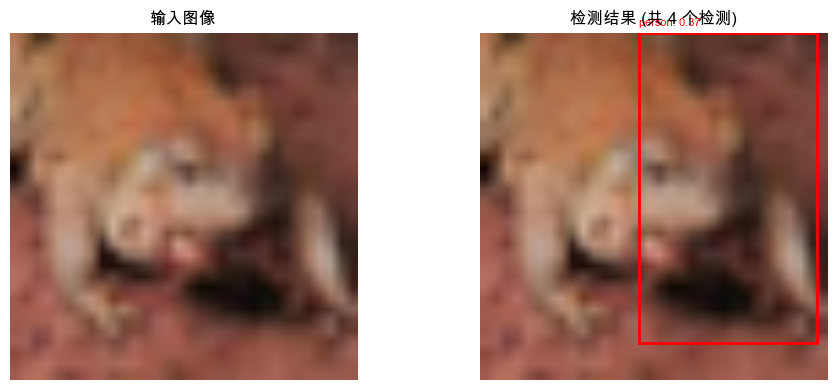

💡 注意：CIFAR-10 图像较小且与 COCO 数据集差异大，检测效果可能不佳。
   在实际应用中，应使用与训练数据相似的图像。


In [16]:
# 创建测试图像并进行检测

# 使用 CIFAR-10 中的图像作为演示
transform = transforms.Compose([transforms.ToTensor()])
test_data = datasets.CIFAR10('./data', train=False, download=True, transform=transform)

# 选择一张图像
img_tensor, label = test_data[5]

# CIFAR-10 图像太小 (32×32)，需要放大
img_resized = F.interpolate(img_tensor.unsqueeze(0), size=(224, 224), mode='bilinear')[0]

# 进行检测
with torch.no_grad():
    predictions = detector([img_resized])

# 可视化结果
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# 原图
axes[0].imshow(img_resized.permute(1, 2, 0).numpy())
axes[0].set_title('输入图像')
axes[0].axis('off')

# 检测结果
axes[1].imshow(img_resized.permute(1, 2, 0).numpy())

pred = predictions[0]
for i, (box, label_id, score) in enumerate(zip(pred['boxes'], pred['labels'], pred['scores'])):
    if score > 0.3:  # 置信度阈值
        x1, y1, x2, y2 = box.numpy()
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, 
                                  linewidth=2, edgecolor='red', facecolor='none')
        axes[1].add_patch(rect)
        axes[1].text(x1, y1-5, f'{categories[label_id]}: {score:.2f}', 
                     color='red', fontsize=8)

axes[1].set_title(f'检测结果 (共 {len(pred["boxes"])} 个检测)')
axes[1].axis('off')

plt.tight_layout()
plt.show()

print("💡 注意：CIFAR-10 图像较小且与 COCO 数据集差异大，检测效果可能不佳。")
print("   在实际应用中，应使用与训练数据相似的图像。")

## 5.2 使用预训练模型进行分割

In [17]:
# 使用预训练的 DeepLabV3 进行语义分割

from torchvision.models.segmentation import deeplabv3_resnet50, DeepLabV3_ResNet50_Weights

print("加载预训练 DeepLabV3...")
weights = DeepLabV3_ResNet50_Weights.DEFAULT
segmentor = deeplabv3_resnet50(weights=weights)
segmentor.eval()

# 获取类别名称
categories = weights.meta['categories']
print(f"可分割的类别数: {len(categories)}")
print(f"类别: {categories}")

加载预训练 DeepLabV3...


Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /Users/lyh/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161M/161M [00:15<00:00, 10.6MB/s]


可分割的类别数: 21
类别: ['__background__', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']


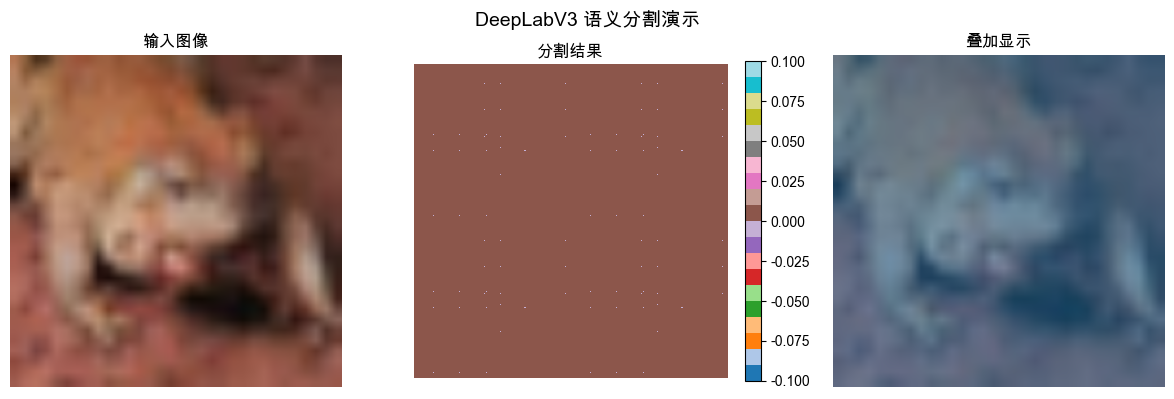

检测到的类别: ['__background__']


In [18]:
# 进行分割

# 放大图像并进行分割
img_for_seg = F.interpolate(img_tensor.unsqueeze(0), size=(256, 256), mode='bilinear')

with torch.no_grad():
    output = segmentor(img_for_seg)['out']  # (1, num_classes, H, W)

# 获取分割结果
seg_mask = output.argmax(1)[0].numpy()  # (H, W)

# 可视化
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# 原图
axes[0].imshow(img_for_seg[0].permute(1, 2, 0).numpy())
axes[0].set_title('输入图像')
axes[0].axis('off')

# 分割结果
im = axes[1].imshow(seg_mask, cmap='tab20')
axes[1].set_title('分割结果')
axes[1].axis('off')
plt.colorbar(im, ax=axes[1], fraction=0.046)

# 叠加显示
axes[2].imshow(img_for_seg[0].permute(1, 2, 0).numpy())
axes[2].imshow(seg_mask, alpha=0.5, cmap='tab20')
axes[2].set_title('叠加显示')
axes[2].axis('off')

plt.suptitle('DeepLabV3 语义分割演示', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# 统计检测到的类别
unique_classes = np.unique(seg_mask)
print(f"检测到的类别: {[categories[c] for c in unique_classes]}")

---

## 📝 本章小结

### 核心知识点

1. **任务层次**：
   - 分类 → 检测 → 语义分割 → 实例分割
   - 输出粒度逐渐精细

2. **IoU（交并比）**：
   - 衡量两个框的重叠程度
   - IoU = 交集面积 / 并集面积

3. **NMS（非极大值抑制）**：
   - 去除重复检测
   - 保留置信度最高的框

4. **YOLO 思想**：
   - 单阶段检测
   - 网格划分 + 直接回归

5. **U-Net 结构**：
   - 编码器-解码器
   - 跳跃连接保留细节

### 关键代码

```python
# IoU 核心计算
inter_area = max(0, x2-x1) * max(0, y2-y1)
iou = inter_area / (area1 + area2 - inter_area)

# NMS 核心逻辑
while len(order) > 0:
    keep.append(order[0])
    order = order[ious <= threshold]
```

---

## 🎯 练习

### 练习 1：手动计算 IoU
**难度**：⭐

计算以下两个框的 IoU：
- Box A: [10, 10, 50, 50]
- Box B: [30, 30, 70, 70]

### 练习 2：多类别 NMS
**难度**：⭐⭐

修改 NMS 函数，使其支持多类别检测（不同类别之间不应该互相抑制）。

### 练习 3：U-Net 深度实验
**难度**：⭐⭐

修改 U-Net 的深度（编码器层数），观察参数量和分割效果的变化。

### 练习 4：在小数据集上训练 U-Net
**难度**：⭐⭐⭐

使用 Oxford Pets 或 VOC 数据集的子集，训练 U-Net 进行二分类分割。

### 练习 5：简单检测训练循环
**难度**：⭐⭐⭐

实现一个简化版 YOLO 的训练循环，包含损失函数设计。

---

## 🚀 下一步

恭喜你完成了 CNN 模块的学习！

建议接下来学习：
- **Transformer 和 Vision Transformer (ViT)**
- **更高级的检测器（如 YOLO v5/v8）**
- **实例分割（Mask R-CNN）**